In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from wordcloud import WordCloud

import pandas as pd
import random, time
from babel.dates import format_date, format_datetime, format_time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score


import torch
from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
import transformers, os
from transformers import BertModel, AutoModel, AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification, BertConfig

from sklearn.feature_extraction.text import TfidfVectorizer
import re
import zipfile

In [2]:
file_path = '/content/translated_ds.xlsx'
# file_path = "D:\\sample\\content2\\translated_df.xlsx"

# selected_columns = ['ICD10', 'transstr']
selected_columns = ['ICD10', 'CC_trans', 'PI_trans']
df = pd.read_excel(file_path, usecols=selected_columns, dtype=str)

df['ICD10'] = df['ICD10'].astype(str)
df['CC_trans'] = df['CC_trans'].astype(str)
df['PI_trans'] = df['PI_trans'].astype(str)

print('전체 데이터 수 :', len(df))
df.head(5)

전체 데이터 수 : 826


,ICD10,PI_trans,CC_trans
0,N391,115-61-61 2023.5.10.Suspicion of proteinuria i...,nan
1,N184,"130/61/69 Symptoms (-), edema (-), urbanic sym...","CKD4, Cr 2.26, eGFR 29ml/min"
2,N184,"153/75/85 osophy (-), edema (-), urinary sympt...",CKD4
3,N185,148/90/64 Idema Mild CKD D/T ADPKD has been tr...,"Cr 3.74, eGFR 13.56"
4,N183,"Hello teacher, I am a patient who is being hos...",lab abnormality


In [3]:
def combine_columns(col_1, col_2):
    result = ''

    if col_1 and col_1 != 'nan':
        result = str(col_1).strip() + '.'

    if col_2:
        result += ' ' + str(col_2).strip()

    return result.strip()

df["record"] = df.apply(lambda x: combine_columns(x['CC_trans'], x['PI_trans']), axis=1)

In [4]:
df.head(10)

,ICD10,PI_trans,CC_trans,record
0,N391,115-61-61 2023.5.10.Suspicion of proteinuria i...,nan,115-61-61 2023.5.10.Suspicion of proteinuria i...
1,N184,"130/61/69 Symptoms (-), edema (-), urbanic sym...","CKD4, Cr 2.26, eGFR 29ml/min","CKD4, Cr 2.26, eGFR 29ml/min. 130/61/69 Sympto..."
2,N184,"153/75/85 osophy (-), edema (-), urinary sympt...",CKD4,"CKD4. 153/75/85 osophy (-), edema (-), urinary..."
3,N185,148/90/64 Idema Mild CKD D/T ADPKD has been tr...,"Cr 3.74, eGFR 13.56","Cr 3.74, eGFR 13.56. 148/90/64 Idema Mild CKD ..."
4,N183,"Hello teacher, I am a patient who is being hos...",lab abnormality,"lab abnormality. Hello teacher, I am a patient..."
5,N184,# R/O AKI # R/O AKI on CKD has never been diag...,lab abnormality,lab abnormality. # R/O AKI # R/O AKI on CKD ha...
6,N184,The patient is a patient of 85 years old (F) c...,lab abnormality,lab abnormality. The patient is a patient of 8...
7,N029,Hematurous Cystitis frequently occurs when che...,hematuria,hematuria. Hematurous Cystitis frequently occu...
8,N184,# T2DM (2017.) # HTN (2018.) # BPH # S/P spina...,CKD f/u,CKD f/u. # T2DM (2017.) # HTN (2018.) # BPH # ...
9,N183,"2023.06 AKI D/T HTN, HEAVY ALCOHOLICS HD #One ...",azotemia,"azotemia. 2023.06 AKI D/T HTN, HEAVY ALCOHOLIC..."


In [5]:
df.shape

(826, 4)

In [6]:
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

torch.cuda.empty_cache()

seed_val = 35

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

There are %d GPU(s) available. 1
We will use the GPU: NVIDIA L4


In [7]:
# temp_df = df[df['ICD10'].isin(['N391', 'N184', 'N185', 'N183', 'N029', 'N182', 'N178', 'R798', 'R311', 'N059', 'Z524'])]
temp_df = df

In [8]:
temp_df.shape

(826, 4)

In [11]:
# 클래스별 최대 크기로 데이터 자름 (특정 클래스만 너무 데이터 양이 많을 때 보정하기 위함)

# 클래스 카테고리
label_dict = temp_df['ICD10'].unique()
category = label_dict.reshape(-1,1)

# 클래스 별 샘플 수 계산
class_counts = temp_df['ICD10'].value_counts()

# 클래스 간 샘플 수의 최솟값 계산 (가장 작은 클래스의 샘플 수)
# min_class_count = class_counts.min()
min_class_count = 100

# 클래스 간 샘플 수를 최솟값에 맞추기 위해 과소 표집 수행
undersampled_dfs = []
for class_label, count in class_counts.items():
    print(f'class_label : {class_label}, count : {count}')
    # 클래스 별 샘플 인덱스 추출
    class_indices = temp_df[temp_df['ICD10'] == class_label].index
    print(f'class_indices : {class_indices}')

    if(count > min_class_count):
        # 최솟값에 맞게 샘플 무작위 선택
        undersampled_indices = temp_df.loc[class_indices].sample(n=min_class_count, replace=False).index
        print(f'undersampled_indices : {len(undersampled_indices)}')
    else:
        undersampled_indices = class_indices

    # 과소 표집된 데이터 프레임 생성
    undersampled_df = temp_df.loc[undersampled_indices]
    print(f'undersampled_df : {undersampled_df}')

    undersampled_dfs.append(undersampled_df)

# 과소 표집된 데이터 프레임 합치기
undersampled_df = pd.concat(undersampled_dfs)

# 샘플을 무작위로 섞기 (섞지 않을 경우 클래스 순서에 따라 편향될 수 있음)
undersampled_df = undersampled_df.sample(frac=1).reset_index(drop=True)

# 과소 표집된 데이터 프레임 출력
print(undersampled_df)

class_label : N183, count : 282
class_indices : Index([  4,   9,  11,  13,  14,  20,  21,  24,  25,  26,
       ...
       797, 805, 807, 810, 811, 815, 816, 819, 820, 821],
      dtype='int64', length=282)
undersampled_indices : 100
undersampled_df :     ICD10                                           PI_trans  \
42   N183  TYPE 2 DM Diagnosis 3 months ago in the mid -5...   
340  N183  2023/04 Dysarthria visited Good Morning Hospit...   
223  N183  # HTN (10Y) # T2DM (10y) # CABG (15Y, Samsung ...   
56   N183  139-77-58 Gunjin Award 2023.6.28.Creatinine 2....   
474  N183  2023.05.03 CAG DM, HTN for 20 years or more 20...   
..    ...                                                ...   
183  N183  HTN Diagnosis in the mid 30s 2022.03 Type 2 DM...   
114  N183  HTN 15 years, T2DM 3 years SYNCOPE, CR 1.4, wh...   
311  N183  Hello, Professor # HBV Related LC-> Liver S6 s...   
378  N183  National Vietnam 2021/04 Ar Severe, R/O Marfan...   
385  N183  The patient is a 76 -year -old (m

In [12]:
undersampled_df.shape

(638, 4)

In [13]:
label_dict

array(['N391', 'N184', 'N185', 'N183', 'N029', 'N182', 'N178', 'R798',
       'R808', 'R311', 'N059', 'Z524', 'N028', 'R601'], dtype=object)

<Axes: xlabel='ICD10', ylabel='count'>

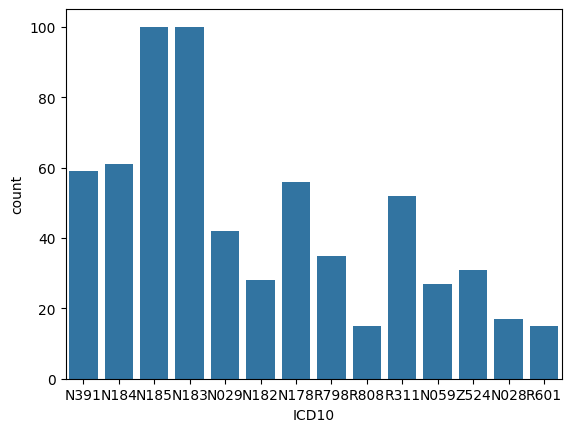

In [14]:
# Plot the count of ICD10 code
sns.countplot(data=undersampled_df, x=undersampled_df['ICD10'], order=label_dict)

In [15]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder를 객체로 생성합니다.
le = LabelEncoder()
# fit_transform()으로 라벨인코딩을 수행합니다.
undersampled_df['encoded_labels'] = le.fit_transform(undersampled_df['ICD10'])

In [16]:
le.classes_

array(['N028', 'N029', 'N059', 'N178', 'N182', 'N183', 'N184', 'N185',
       'N391', 'R311', 'R601', 'R798', 'R808', 'Z524'], dtype=object)

In [25]:
le.classes_[0]

'N028'

In [26]:
texts = undersampled_df['record']
labels = undersampled_df['ICD10']
encoded_labels = undersampled_df['encoded_labels']

In [27]:
undersampled_df.shape

(638, 5)

In [ ]:
# undersampled_df.record = undersampled_df.record.str.replace('[#,@,&]', '')
# # Remove digits
# undersampled_df.record = undersampled_df.record.str.replace('\d*','')
# #Remove www
# undersampled_df.record = undersampled_df.record.str.replace('w{3}','')
# # remove urls
# undersampled_df.record = undersampled_df.record.str.replace("http\S+", "")
# # remove multiple spaces with single space
# undersampled_df.record = undersampled_df.record.str.replace('\s+', ' ')
# #remove all single characters
# undersampled_df.record = undersampled_df.record.str.replace(r'\s+[a-zA-Z]\s+', '')
# # 여러번 반복되는 문자 하나만 표현
# undersampled_df.record = undersampled_df.record.str.replace('=+', ' ')

In [28]:
def clean_str(string):
    # string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    # string = re.sub(r"\'s", " \'s", string)
    # string = re.sub(r"\'ve", " \'ve", string)
    # string = re.sub(r"n\'t", " n\'t", string)
    # string = re.sub(r"\'re", " \'re", string)
    # string = re.sub(r"\'d", " \'d", string)
    # string = re.sub(r"\'ll", " \'ll", string)
    # string = re.sub(r",", " , ", string)
    # string = re.sub(r"!", " ! ", string)
    # string = re.sub(r"\(", " \( ", string)
    # string = re.sub(r"\)", " \) ", string)
    # string = re.sub(r"\?", " \? ", string)
    # string = re.sub(r"\s{2,}", " ", string)
    # string = re.sub(r" , ", " ", string)

    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " ( ", string)
    string = re.sub(r"\)", " ) ", string)
    string = re.sub(r"\?", " ? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r" , ", " ", string)
    return string.strip().lower()


def preprocess_data(sentences):
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

    tokenize_sentences = []
    word_list_dict = {}

    for sentence in sentences:
        temp = clean_str(sentence)
        word_list_temp = temp.split()
        doc_words = []
        for word in word_list_temp:
            if word not in stop_words:
                doc_words.append(word)
                word_list_dict[word] = 1
        doc_word_result = ' '.join(doc_words)
        tokenize_sentences.append(doc_word_result)
    word_list = list(word_list_dict.keys())

    return tokenize_sentences, word_list

tokenize_texts, word_list = preprocess_data(texts)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
texts[:10]

0    azotemia. The patient is a patient of 64 years...
1    Cr elevation. Inspection, which was conducted ...
2    hematuria. 2023-3.RT.Flank Pain, hematuria fin...
3    Kidney donor. 121/59/79 Visit for kidney donat...
4    Proteinuria. I heard that there was proteinuri...
5    Difficulty breathing. I have never heard of un...
6    Left. flank pain for several months. 154/89/86...
7    for evaluation of proteinuria. More than 20 ye...
8    114-69-88 2 years ago Urology and Browno Holy ...
9    azotemia. The patient is a patient of 51 years...
Name: record, dtype: object

In [30]:
tokenize_texts[:10]

["azotemia patient patient 64 years old ( f ) currently treated diagnostic name herpes zoster herpes used use antiviral drugs due frequent recurrence risen cr 1 0 2022 12 28 test please busy thank youi ask derma prof r1 n't good condition december last year 144 74 74",
 "cr elevation inspection conducted orthopedic follow tingling sensation cr 's upheartes 115 78 117 keys weight 172cm 73kg job student general condition good ecog ps 0 htn none dm none recentcr numerical 1 21 egfr 69 5 recent bubbles hematuria ( ) edema body weight change none medication amchoval herbal medicine health auxiliary food worn characters juice none renewal family history dialysis history none recent 2 3the calf tired month taking control anti inflammatory drugs 2 3 weeks health movement regularly since three years went gym 4 5 times week took protein supplements",
 'hematuria 2023 3 rt flank pain hematuria finds previous examination hematuria gross hematuria ( ) urinary sx ( )',
 'kidney donor 121 59 79 visit

In [32]:
labels[:10]

0    N178
1    R798
2    N029
3    Z524
4    N391
5    N185
6    N185
7    N391
8    R311
9    N178
Name: ICD10, dtype: object

In [53]:
# 레이블 인코딩
# label2idx = {label: idx for idx, label in enumerate(set(labels))}
# encoded_labels = [label2idx[label] for label in labels]
# encoded_labels = torch.LongTensor(encoded_labels)

In [31]:
# type(tokenize_texts)
encoded_labels[:10]

0     3
1    11
2     1
3    13
4     8
5     7
6     7
7     8
8     9
9     3
Name: encoded_labels, dtype: int64

In [33]:
target_df = pd.DataFrame({'texts': tokenize_texts, 'labels': encoded_labels})

In [34]:
target_df.replace('', np.nan, inplace=True)
target_df = target_df.dropna()

In [35]:
target_df.shape

(638, 2)

In [36]:
X_train, X_temp, y_train, y_temp = train_test_split(target_df['texts'], target_df['labels'], test_size=0.3, random_state=52, stratify=target_df['labels'])
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=73, stratify=y_temp)

In [64]:
X_train[0]

'proteinuria hematuria recent recruitment examination 2023 08 17 cr 0 8 egfr 82 proteinuria suspected bp 133 86 88'

In [65]:
y_train[0]

7

<Axes: xlabel='labels', ylabel='count'>

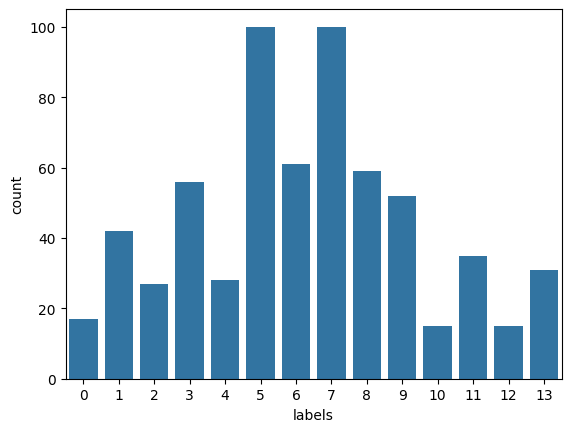

In [37]:
# Plot the count of ICD10 code
sns.countplot(data=target_df, x=target_df['labels'])

In [38]:
# BERT 토크나이저와 모델 불러오기
model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"
config = BertConfig.from_pretrained(model_checkpoint)

# num_labels 설정
num_labels = len(label_dict)

# config 수정
config.num_labels = num_labels

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
bertmodel = AutoModel.from_pretrained(model_checkpoint, config=config)
# model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, config=config)

# # 사용자 정의 분류기 추가
# class CustomClassifier(nn.Module):
#     def __init__(self, num_labels):
#         super(CustomClassifier, self).__init__()
#         self.num_labels = num_labels
#         self.classifier = nn.Linear(model.config.hidden_size, self.num_labels)

#     def forward(self, hidden_states):
#         logits = self.classifier(hidden_states)
#         return logits

class BERTClassifier(nn.Module):
    def __init__(self, bertmodel, num_labels):
        super(BERTClassifier, self).__init__()
        self.bert = bertmodel
        self.num_labels = num_labels
        self.classifier = nn.Linear(768, num_labels) # tinybert=312, bert-base=768
        self.dropout = nn.Dropout(0.1)


    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.bert(input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        pooler = output['pooler_output']
        pooler = self.dropout(pooler)
        fc_layer = self.classifier(pooler)
        return fc_layer

# 기존 모델의 분류기를 사용자 정의 분류기로 대체
model = BERTClassifier(bertmodel=bertmodel, num_labels=num_labels)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [39]:
print(model.num_labels)

14


In [ ]:
# # 데이터 전처리: 텍스트를 인코딩하고 텐서로 변환
# # inputs = []
# input_ids_list = []
# attention_mask_list = []

# max_length = 128

# for text in tokenize_texts:
#     # 각 텍스트를 토큰화하여 tokenizer에 전달하고 결과를 리스트에 추가
#     tokenized_input = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
#     # inputs.append(tokenized_input)
#     input_ids_list.append(tokenized_input['input_ids'])
#     attention_mask_list.append(tokenized_input['attention_mask'])

In [ ]:
# max_tensor_size = max(tensor.shape for tensor in input_ids_list)

# print("가장 긴 텐서의 크기:", max_tensor_size)

가장 긴 텐서의 크기: torch.Size([1, 128])


In [ ]:
# 텐서로 변환
# input_ids_tensor = torch.cat(input_ids_list, dim=0)
# attention_mask_tensor = torch.cat(attention_mask_list, dim=0)

embedded_data : [[-40.128918  -10.392903 ]
 [ 15.406436   17.601385 ]
 [ 28.684483   18.123854 ]
 ...
 [-11.369315   -2.082267 ]
 [  7.315951   -2.7485607]
 [-13.160764    1.1267109]]


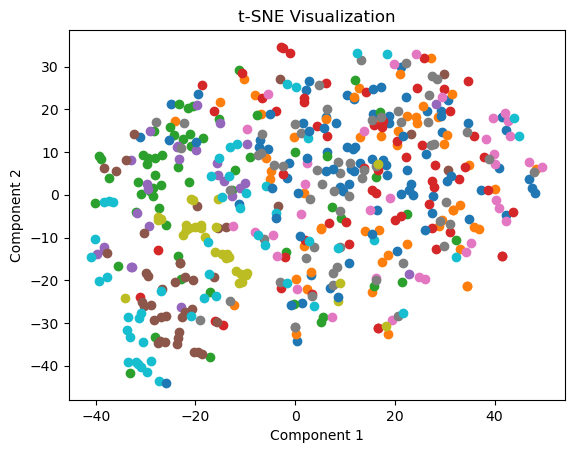

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# def convert_tensorlist_to_array(tList):
#     data = np.array([])

#     for ts in tList:
#         arr = ts.numpy().flatten()

#         if data.size == 0:
#             data = arr
#         else:
#             data = np.vstack((data, arr))
#     return data

# data = convert_tensorlist_to_array(input_ids_list)
# labels = np.array(encoded_labels)

# # print(data)
# # print()
# # print(labels)
# # t-SNE 적용
# tsne = TSNE(n_components=2, perplexity=10)  # 예시로 perplexity 값을 5로 설정
# embedded_data = tsne.fit_transform(data)

# for label in np.unique(labels):
#     mask = labels == label
#     plt.scatter(embedded_data[mask, 0], embedded_data[mask, 1], label=f'Label {label}')

# print(f'embedded_data : {embedded_data}')
# # 시각화
# # plt.figure(figsize=(8, 6))
# # plt.scatter(embedded_data[:, 0], embedded_data[:, 1])
# plt.title('t-SNE Visualization')
# plt.xlabel('Component 1')
# plt.ylabel('Component 2')
# plt.show()

In [40]:
SEQ_LEN = 128

train_encoding = tokenizer.batch_encode_plus(
  list(X_train),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='max_length',
  return_attention_mask=True,
)

test_encoding = tokenizer.batch_encode_plus(
  list(X_test),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='max_length',
  return_attention_mask=True,
)

val_encoding = tokenizer.batch_encode_plus(
  list(X_val),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='max_length',
  return_attention_mask=True,
)

In [42]:
# 하이퍼파라미터 설정
batch_size = 32
learning_rate = 5e-5
epochs = 10

In [ ]:
type(y_train)

pandas.core.series.Series

In [43]:
def loadData(prep_df, batch_size, sampler):

    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            sampler=sampler,
            pin_memory=True
        )

## convert lists to tensors
train_seq = torch.tensor(train_encoding['input_ids'])
train_mask = torch.tensor(train_encoding['attention_mask'])
train_token_ids = torch.tensor(train_encoding['token_type_ids'])
train_y = torch.tensor(y_train.values)
# train_onehot_y = torch.tensor(y_train_dense, requires_grad=True)
# train_y = torch.argmax(train_onehot_y, dim=-1)

test_seq = torch.tensor(test_encoding['input_ids'])
test_mask = torch.tensor(test_encoding['attention_mask'])
test_token_ids = torch.tensor(test_encoding['token_type_ids'])
test_y = torch.tensor(y_test.values)
# test_onehot_y = torch.tensor(y_test_dense)
# test_y = torch.argmax(test_onehot_y, dim=-1)

val_seq = torch.tensor(val_encoding['input_ids'])
val_mask = torch.tensor(val_encoding['attention_mask'])
val_token_ids = torch.tensor(val_encoding['token_type_ids'])
val_y = torch.tensor(y_val.values)
# val_onehot_y = torch.tensor(y_val_dense)
# val_y = torch.argmax(val_onehot_y, dim=-1)

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_token_ids, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# Train Data Loader
traindata = loadData(train_data, batch_size, train_sampler)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, test_sampler)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_token_ids, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# Val Data Loader
valdata = loadData(val_data, len(val_data), val_sampler)


print('Number of data in the train set', len(traindata))
print('Number of data in the test set', len(testdata))
print('Number of data in the validation set', len(valdata))

Number of data in the train set 14
Number of data in the test set 3
Number of data in the validation set 1


In [ ]:
from transformers import Trainer, TrainingArguments

# 학습 인자 설정
training_args = TrainingArguments(
    output_dir="D:\\sample\\model\\BERT_results.txt",
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_dir="D:\\sample\\model\\BERT_logs.txt",
)

# 트레이너 생성
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=traindata,
    eval_dataset=testdata,
    compute_metrics=lambda pred: {"accuracy": accuracy_score(pred.label_ids, pred.predictions.argmax(axis=1))},
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [45]:
#compute the class weights
unique_encoded_label = target_df['labels'].unique()

class_wts = compute_class_weight(classes=unique_encoded_label, y=target_df['labels'], class_weight='balanced')

#print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
criterion = nn.CrossEntropyLoss(weight=weights)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

In [46]:
unique_encoded_label

array([ 3, 11,  1, 13,  8,  7,  9,  5,  4, 10,  6,  2,  0, 12])

In [47]:
weights

tensor([0.8138, 1.3020, 1.0850, 1.4700, 0.7724, 0.4557, 0.8764, 0.4557, 1.6276,
        3.0381, 0.7471, 1.6878, 2.6807, 3.0381], device='cuda:0')

In [ ]:
# # 학습
# epochs = 10
# for epoch in range(epochs):

#     model.train()
#     for step, batch in enumerate(traindata):
#         input_ids, attention_mask, labels = batch

#         labels = labels.long()
#         # labels = torch.argmax(labels, dim=1)

#         optimizer.zero_grad()
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()

#     # 검증
#     model.eval()
#     val_loss = 0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for batch in testdata:
#             input_ids, attention_mask, labels = batch
#             outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#             val_loss += outputs.loss.item()
#             _, predicted = torch.max(outputs.logits, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     val_loss /= len(val_loader)
#     accuracy = correct / total
#     print(f'Epoch {epoch+1}/{epochs}, Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

ValueError: too many values to unpack (expected 3)

In [ ]:
# def train_model(epochs, early_stopping, model, optimizer, criterion, features, adj, labels, idx_train, idx_val, show_result = True):
#     val_loss = []
#     for epoch in range(epochs):
#         t = time.time()
#         model.train()
#         optimizer.zero_grad()
#         _, output= model(features, adj)
#         loss_train = criterion(output[idx_train], labels[idx_train])
#         acc_train = cal_accuracy(output[idx_train], labels[idx_train])

#         loss_train.backward()
#         optimizer.step()

#         model.eval()
#         _, output = model(features, adj)

#         loss_val = criterion(output[idx_val], labels[idx_val])
#         val_loss.append(loss_val.item())
#         acc_val = cal_accuracy(output[idx_val], labels[idx_val])
#         if show_result:
#             print(  'Epoch: {:04d}'.format(epoch+1),
#                     'loss_train: {:.4f}'.format(loss_train.item()),
#                     'acc_train: {:.4f}'.format(acc_train),
#                     'loss_val: {:.4f}'.format(loss_val.item()),
#                     'acc_val: {:.4f}'.format(acc_val),
#                     'time: {:.4f}s'.format(time.time() - t))

#         if epoch > early_stopping and np.min(val_loss[-early_stopping:]) > np.min(val_loss[:-early_stopping]) :
#             if show_result:
#                 print("Early Stopping...")
#             break

In [48]:
from sklearn.metrics import accuracy_score

def calc_accuracy(predictions, labels):
    pred = torch.argmax(predictions,-1).cpu().tolist()
    lab = labels.cpu().tolist()
    print(f'pred : {pred}')
    print(f'label : {lab}')
    return accuracy_score(lab,pred)

In [49]:
# function to train the bert model
def trainBERT():

    print('Training...')
    model.train()
    total_loss, total_accuracy = 0, 0
    avg_loss, avg_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step, batch in enumerate(traindata):

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [r.to(device) for r in batch]

        sent_id, mask, token_type_ids, labels = batch

        labels = labels.long()

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask, token_type_ids)

        # top_values, top_indices = torch.topk(preds, k=5, dim=1)

        # print(f"preds : {preds} --- {top_values} --- {top_indices} --- {labels}")

        # compute the loss between actual and predicted values
        loss = criterion(preds, labels)
        # print(f"loss : {loss}")

        # add on to the total loss
        total_accuracy += calc_accuracy(preds, labels)
        total_loss += loss.item()

        optimizer.zero_grad()

        # backward pass to calculate the gradients
        loss.requires_grad_(True)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # # append the model predictions
        total_preds.append(preds)
        # print(f"total_preds : {total_preds}")
        torch.cuda.empty_cache()

    print(f"total_accuracy : {total_accuracy}")
    print(f"total_loss : {total_loss}")
    print(f"len(traindata) : {len(traindata)}")

    # compute the training loss of the epoch
    avg_loss = total_loss / len(traindata)
    avg_accuracy = total_accuracy / len(traindata)

    # print(f"total_preds : {total_preds}")

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, avg_accuracy, total_preds

In [50]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")
    t0 = time.time()

    model.eval() # deactivate dropout layers
    total_loss, total_accuracy = 0, 0
    avg_loss, avg_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(testdata):

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [t.to(device) for t in batch]

        sent_id, mask, token_type_ids, labels = batch

        labels = labels.long()
        # labels = torch.argmax(labels, dim=1)
        # deactivate autograd
        with torch.no_grad(): # Dont store any previous computations, thus freeing GPU space

            # model predictions
            preds = model(sent_id, mask, token_type_ids)
            # compute the validation loss between actual and predicted values
            loss = criterion(preds, labels)

            total_accuracy += calc_accuracy(preds, labels)
            total_loss += loss.item()

            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

        torch.cuda.empty_cache()
    # compute the test loss of the epoch
    avg_loss = total_loss / len(testdata)
    avg_accuracy = total_accuracy / len(testdata)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, avg_accuracy, total_preds

In [52]:
# set initial loss to infinite
best_test_loss = float('inf')

# Empty lists to store training and test loss of each epoch
train_losses=[]
test_losses=[]
train_acc=[]
test_acc=[]

# for each epoch perform training and evaluation
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, train_acc, _ = trainBERT()

    #evaluate model
    test_loss, test_acc, _ = evaluate()

    print('\n Done for epoch {} -- train accuracy : {} -- train loss : {} -- test accuracy : {} -- test loss : {}'.format(epoch + 1, train_acc, train_loss, test_acc, test_loss))

    #save the best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        print('Saving model...')
        # torch.save(model.state_dict(), 'D:\\sample\\content2\\bert_weights_5.pt') # Save model weight's (you can also save it in .bin format)
        torch.save(model.state_dict(), '/content/bert_weights_5.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Test Loss: {test_loss:.3f}')


 Epoch 1 / 10
Training...
pred : [9, 3, 9, 13, 9, 8, 13, 8, 9, 9, 9, 8, 9, 13, 13, 9, 9, 9, 8, 9, 13, 9, 9, 9, 8, 9, 8, 8, 9, 13, 9, 8]
label : [7, 4, 7, 6, 7, 5, 13, 3, 6, 3, 6, 9, 11, 11, 9, 10, 6, 4, 7, 7, 7, 4, 9, 5, 6, 12, 9, 5, 6, 11, 1, 8]
pred : [9, 9, 8, 9, 8, 13, 13, 8, 13, 13, 9, 9, 9, 9, 9, 8, 9, 13, 9, 13, 9, 13, 9, 9, 9, 9, 9, 9, 13, 13, 13, 8]
label : [12, 3, 8, 6, 7, 4, 7, 7, 13, 7, 7, 9, 7, 3, 7, 9, 9, 13, 8, 12, 7, 5, 4, 7, 5, 5, 3, 0, 9, 13, 4, 3]
pred : [13, 9, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 13, 9, 8, 9, 13, 8, 13, 13, 8, 13, 13, 9, 9, 13, 13, 9, 13, 13]
label : [3, 3, 2, 1, 3, 5, 7, 6, 9, 2, 2, 5, 0, 0, 3, 9, 2, 5, 5, 8, 11, 11, 8, 5, 4, 8, 7, 7, 3, 3, 4, 13]
pred : [13, 13, 13, 9, 13, 9, 13, 9, 9, 9, 8, 8, 9, 9, 13, 3, 9, 13, 3, 9, 9, 3, 8, 9, 9, 13, 9, 9, 9, 9, 9, 9]
label : [13, 5, 7, 10, 10, 6, 13, 5, 6, 0, 3, 8, 8, 5, 9, 3, 3, 13, 7, 4, 9, 6, 4, 2, 8, 6, 2, 5, 7, 5, 5, 8]
pred : [9, 13, 9, 8, 9, 9, 3, 3, 8, 13, 13, 8, 9, 8, 9, 9, 9, 8, 9, 8, 9, 9, 8, 9, 

In [53]:
print('\nValidation Set...')

valid_preds = []
true_labels = []

print('Total batches:', len(valdata))

# Load the fold model
# path_model = 'D:\\sample\\content2\\bert_weights_4.pt'
path_model = '/content/bert_weights_5.pt'
model.load_state_dict(torch.load(path_model))

# Send the model to the GPU
model.to(device)

stacked_val_labels = []

# Put the model in evaluation mode.
model.eval()

# Turn off the gradient calculations.
# This tells the model not to compute or store gradients.
# This step saves memory and speeds up validation.
torch.set_grad_enabled(False)


# Reset the total loss for this epoch.
total_val_loss, total_val_accuracy = 0, 0
avg_val_loss, avg_val_accuracy = 0, 0

for j, val_batch in enumerate(valdata):
    b_input_ids = val_batch[0].to(device)
    b_input_mask = val_batch[1].to(device)
    b_token_type_ids = val_batch[2].to(device)
    b_val_y = val_batch[3].to(device)

    outputs = model(b_input_ids,
                    attention_mask=b_input_mask,
                    token_type_ids=b_token_type_ids)

    # Get the preds
    preds = outputs
    print(f'********************** j : {j}')
    # Move preds to the CPU
    val_preds = preds.detach().cpu().numpy()
    print(f'predicted label : {val_preds}')
    true_labels.append(b_val_y.to('cpu').numpy())
    print(f"true label : {b_val_y.to('cpu').numpy()}")

    # Stack the predictions.
    if j == 0:  # first batch
        stacked_val_preds = val_preds

    else:
        stacked_val_preds = np.vstack((stacked_val_preds, val_preds))

valid_preds.append(stacked_val_preds)

print('\nPrediction complete.')

torch.utils.data.dataloader.DataLoader